#### Imports

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
from sklearn.preprocessing import RobustScaler

In [40]:
df = pd.read_csv('../../Datasets/final_dataset_descr.csv', sep='\t')

In [41]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age
0,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
1,201701,10002,20001,0,17,38.68301,35.72806,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
2,201701,10003,20001,0,17,143.49426,143.49426,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
3,201701,10004,20001,0,9,184.72927,184.72927,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0
4,201701,10005,20001,0,23,19.08407,19.08407,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0,0


#### Paso 1: Filtrar y eliminar productos con poca historia


Completamos el dataset con 0 para los producto / cliente que no existen

In [ ]:
# product_ids = [20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012]

In [ ]:
# filtered_df = df[df['product_id'].isin(product_ids)]

In [ ]:
# display(filtered_df)

In [ ]:
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

df = df[df['periodo'] >= '2018-12-01']

product_info = df[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'descripcion']].drop_duplicates()

min_max_periods = df.groupby(['customer_id', 'product_id'])['periodo'].agg(['min', 'max']).reset_index()

all_dfs = []

cont = 1

for _, row in min_max_periods.iterrows():
    customer_id = row['customer_id']
    product_id = row['product_id']
    min_period = row['min']
    max_period = '2019-12-01'
    all_periods = pd.date_range(min_period, max_period, freq='MS')
    
    combinations = pd.DataFrame({
        'customer_id': [customer_id] * len(all_periods),
        'product_id': [product_id] * len(all_periods),
        'periodo': all_periods
    })
    
    merged_df = pd.merge(combinations, df, on=['customer_id', 'product_id', 'periodo'], how='left')
    
    merged_df['tn'] = merged_df['tn'].fillna(0)
    
    merged_df['tn'] = merged_df['tn'].fillna(0)
    merged_df['cat1'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat1'])
    merged_df['cat2'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat2'])
    merged_df['cat3'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat3'])
    merged_df['brand'] = merged_df['product_id'].map(product_info.set_index('product_id')['brand'])
    merged_df['sku_size'] = merged_df['product_id'].map(product_info.set_index('product_id')['sku_size'])
    merged_df['descripcion'] = merged_df['product_id'].map(product_info.set_index('product_id')['descripcion'])
    
    merged_df['quarter'] = 'Q' + merged_df['periodo'].dt.to_period('Q').astype(str).str[-1]
    merged_df['month'] = merged_df['periodo'].dt.month.astype(str).str.zfill(2)
    
    merged_df['plan_precios_cuidados'] = merged_df['plan_precios_cuidados'].fillna(0)
    merged_df['cust_request_qty'] = merged_df['cust_request_qty'].fillna(0)
    merged_df['cust_request_tn'] = merged_df['cust_request_tn'].fillna(0)
    merged_df['close_quarter'] = merged_df['close_quarter'].fillna(0)
    merged_df['age'] = merged_df['age'].fillna(0)
    merged_df['mes_inicial'] = min_period
    
    all_dfs.append(merged_df)
    
    print(f"procesado {cont} de {len(min_max_periods)}")
    cont += 1

df_full = pd.concat(all_dfs, ignore_index=True)

df_full = df_full.sort_values(by=['customer_id', 'product_id', 'periodo'])

df_full['periodo'] = df_full['periodo'].dt.strftime('%Y%m')

display(df_full)

In [23]:
df_full.to_csv('final_dataset_completo_con_ceros.csv', sep='\t')

In [5]:
df_full = pd.read_csv("../../Datasets/final_dataset_completo_con_ceros.csv", sep='\t')

In [45]:
display(df_full)

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,254.62373,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q4,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,386.60688,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,1,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,309.90610,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,2,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,130.54927,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,3,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,364.37071,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q2,4,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10618,20845,201912,0.0,0.0,0.00000,0.00000,HC,PROFESIONAL,PISOS,MUSCULO,5000,Profesional menta,Q4,12,0.0,0.0,2019-11-01
2040579,10618,20886,201911,0.0,1.0,0.01884,0.01884,HC,PROFESIONAL,Gel,MUSCULO,5000,Industrial 5L,Q4,11,0.0,4.0,2019-11-01
2040580,10618,20886,201912,0.0,0.0,0.00000,0.00000,HC,PROFESIONAL,Gel,MUSCULO,5000,Industrial 5L,Q4,12,0.0,0.0,2019-11-01
2040581,10618,20953,201911,0.0,1.0,0.01817,0.01817,HC,PROFESIONAL,PISOS,MUSCULO,5000,Profesinal pisos plastificados,Q4,11,0.0,4.0,2019-11-01


In [6]:
df_full = df_full.drop(columns=['Unnamed: 0'])

#### Paso 2: Aplicar LabelEncoder a las columnas categóricas


In [7]:
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'quarter']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

display(df_full)

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,254.62373,1,10,47,0,3000,384,3,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,386.60688,1,10,47,0,3000,384,0,1,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,309.90610,1,10,47,0,3000,384,0,2,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,130.54927,1,10,47,0,3000,384,0,3,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,364.37071,1,10,47,0,3000,384,1,4,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10618,20845,201912,0.0,0.0,0.00000,0.00000,1,8,54,21,5000,260,3,12,0.0,0.0,2019-11-01
2040579,10618,20886,201911,0.0,1.0,0.01884,0.01884,1,8,31,21,5000,158,3,11,0.0,4.0,2019-11-01
2040580,10618,20886,201912,0.0,0.0,0.00000,0.00000,1,8,31,21,5000,158,3,12,0.0,0.0,2019-11-01
2040581,10618,20953,201911,0.0,1.0,0.01817,0.01817,1,8,54,21,5000,256,3,11,0.0,4.0,2019-11-01


#### Paso 4: Agrupar ventas por periodo, cat1, cat2, cat3, brand, customer_id y product_id


Aplico escalado

In [8]:
scalers = {}
scaled_data = []

for (product_id, customer_id), group in df_full.groupby(['product_id', 'customer_id']):
    group = group.copy()
    scaler = RobustScaler()
    group['tn'] = scaler.fit_transform(group[['tn']])
    
    # Guardar el scaler en el diccionario con una clave única
    key = f'{product_id}_{customer_id}'
    scalers[key] = scaler
    
    # Añadir el grupo escalado a la lista
    scaled_data.append(group)

scaled_df = pd.concat(scaled_data, ignore_index=True)

joblib.dump(scalers, 'scalers.pkl')

scaled_df.to_csv('scaled_final_dataset.csv', sep='\t', index=False)

In [48]:
df_full

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,254.62373,1,10,47,0,3000,384,3,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,386.60688,1,10,47,0,3000,384,0,1,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,309.90610,1,10,47,0,3000,384,0,2,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,130.54927,1,10,47,0,3000,384,0,3,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,364.37071,1,10,47,0,3000,384,1,4,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10618,20845,201912,0.0,0.0,0.00000,0.00000,1,8,54,21,5000,260,3,12,0.0,0.0,2019-11-01
2040579,10618,20886,201911,0.0,1.0,0.01884,0.01884,1,8,31,21,5000,158,3,11,0.0,4.0,2019-11-01
2040580,10618,20886,201912,0.0,0.0,0.00000,0.00000,1,8,31,21,5000,158,3,12,0.0,0.0,2019-11-01
2040581,10618,20953,201911,0.0,1.0,0.01817,0.01817,1,8,54,21,5000,256,3,11,0.0,4.0,2019-11-01


In [9]:
display(scaled_df)

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,0.414840,1,10,47,0,3000,384,3,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,1.150709,1,10,47,0,3000,384,0,1,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,0.723065,1,10,47,0,3000,384,0,2,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,-0.276935,1,10,47,0,3000,384,0,3,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,1.026732,1,10,47,0,3000,384,1,4,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10495,21276,201912,0.0,0.0,0.00000,0.000000,2,6,18,23,140,412,3,12,0.0,0.0,2019-03-01
2040579,10550,21276,201909,0.0,1.0,0.00075,0.251678,2,6,18,23,140,412,2,9,1.0,6.0,2019-09-01
2040580,10550,21276,201910,0.0,0.0,0.00000,-0.251678,2,6,18,23,140,412,3,10,0.0,0.0,2019-09-01
2040581,10550,21276,201911,0.0,2.0,0.00371,2.238255,2,6,18,23,140,412,3,11,0.0,8.0,2019-09-01


In [10]:
scaled_df.dtypes

customer_id                int64
product_id                 int64
periodo                    int64
plan_precios_cuidados    float64
cust_request_qty         float64
cust_request_tn          float64
tn                       float64
cat1                       int32
cat2                       int32
cat3                       int32
brand                      int32
sku_size                   int64
descripcion                int32
quarter                    int32
month                      int64
close_quarter            float64
age                      float64
mes_inicial               object
dtype: object

Agrupo y sumarizo

In [11]:
grouped_df = scaled_df.groupby(['periodo', 'cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'product_id', 'quarter', 'month']).agg({
    'cust_request_qty': 'sum',
    'cust_request_tn': 'sum',
    'tn': 'sum'
}).reset_index()


In [13]:
display(grouped_df[(grouped_df["customer_id"] == 10001) & (grouped_df["product_id"] == 20001)])

,periodo,cat1,cat2,cat3,brand,customer_id,product_id,quarter,month,cust_request_qty,cust_request_tn,tn
15840,201812,1,10,47,0,10001,20001,3,12,20.0,254.62373,0.414840
80495,201901,1,10,47,0,10001,20001,0,1,53.0,393.26092,1.150709
175202,201902,1,10,47,0,10001,20001,0,2,39.0,309.90610,0.723065
294172,201903,1,10,47,0,10001,20001,0,3,23.0,142.87158,-0.276935
431929,201904,1,10,47,0,10001,20001,1,4,33.0,364.37071,1.026732
583070,201905,1,10,47,0,10001,20001,1,5,31.0,439.90647,1.447880
744214,201906,1,10,47,0,10001,20001,1,6,7.0,65.92436,-0.637249
916759,201907,1,10,47,0,10001,20001,2,7,14.0,144.78714,-0.197552
1099078,201908,1,10,47,0,10001,20001,2,8,9.0,33.63991,-0.817251
1288478,201909,1,10,47,0,10001,20001,2,9,18.0,111.51691,-0.396790


Aplico DTW para agrupar los registros (series de categorias/clientes similares)

In [14]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

pivoted_df = grouped_df.pivot_table(index=['cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'product_id'], columns='periodo', values='tn').fillna(0)

inertia = []
max_clusters = 30

for k in range(4, max_clusters + 1):
    print(f"Running K: {k}")
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    model.fit(pivoted_df.values)
    inertia.append(model.inertia_)
    display(inertia)


Running K: 4


[201.24771985048068]

Running K: 5


[201.24771985048068, 137.553850306381]

Running K: 6


[201.24771985048068, 137.553850306381, 96.87338358773088]

Running K: 7


[201.24771985048068, 137.553850306381, 96.87338358773088, 85.72072365972487]

Running K: 8


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245]

Running K: 9


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018]

Running K: 10


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777]

Running K: 11


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753]

Running K: 12


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535]

Running K: 13


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366]

Running K: 14


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852]

Running K: 15


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347]

Running K: 16


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498]

Running K: 17


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417]

Running K: 18


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704]

Running K: 19


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688]

Running K: 20


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661]

Running K: 21


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427]

Running K: 22


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257]

Running K: 23


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385]

Running K: 24


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628]

Running K: 25


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378]

Running K: 26


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396]

Running K: 27


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396,
 10.021213243866171]

Running K: 28


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396,
 10.021213243866171,
 9.649648409380287]

Running K: 29


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396,
 10.021213243866171,
 9.649648409380287,
 9.266289762390391]

Running K: 30


[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396,
 10.021213243866171,
 9.649648409380287,
 9.266289762390391,
 8.87523147261854]

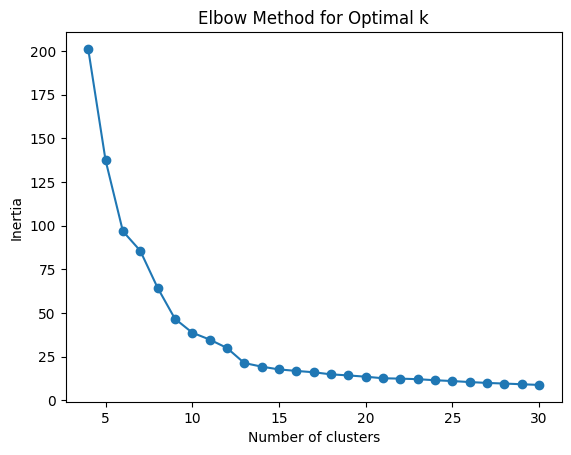

In [15]:
plt.plot(range(4, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [16]:
display(inertia)

[201.24771985048068,
 137.553850306381,
 96.87338358773088,
 85.72072365972487,
 64.53113674297245,
 46.77327304188018,
 38.79747247461777,
 34.863324599753,
 30.055656405218535,
 21.41311411413366,
 19.348382947544852,
 17.7480160000347,
 16.896793680388498,
 16.119390661629417,
 14.928571230714704,
 14.316677975675688,
 13.585275197369661,
 12.68656573572427,
 12.475686394750257,
 12.166305165401385,
 11.555264529360628,
 11.094164689926378,
 10.511553266096396,
 10.021213243866171,
 9.649648409380287,
 9.266289762390391,
 8.87523147261854]

In [54]:
# Debug de los valores
max_value = pivoted_df[201812].max()
min_value = pivoted_df[201812].min()

print(f"Máximo valor de la columna 'nombre_de_la_columna': {max_value}")
print(f"Mínimo valor de la columna 'nombre_de_la_columna': {min_value}")


Máximo valor de la columna 'nombre_de_la_columna': 3.4641016151377557
Mínimo valor de la columna 'nombre_de_la_columna': -2.479356382671416


In [17]:
n_clusters = 26
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
cluster_labels = model.fit_predict(pivoted_df.values)

pivoted_df['cluster'] = cluster_labels

grouped_df = grouped_df.merge(pivoted_df['cluster'], left_on=['cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'product_id'], right_index=True)

grouped_df.to_csv('grouped_with_26_clusters_scaled.csv', index=False)

display(grouped_df)

,periodo,cat1,cat2,cat3,brand,customer_id,product_id,quarter,month,cust_request_qty,cust_request_tn,tn,cluster
0,201812,0,0,4,22,10001,20609,3,12,6.0,0.87535,1.672140,0
56363,201901,0,0,4,22,10001,20609,0,1,4.0,0.30925,-0.098361,0
142485,201902,0,0,4,22,10001,20609,0,2,4.0,0.26732,-0.229499,0
254556,201903,0,0,4,22,10001,20609,0,3,4.0,0.38264,0.131169,0
387941,201904,0,0,4,22,10001,20609,1,4,1.0,0.06290,-0.868831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039694,201912,2,7,79,23,10018,20651,3,12,1.0,0.03870,0.000000,0
2039867,201912,2,7,79,23,10139,20642,3,12,1.0,0.00258,0.000000,0
2039868,201912,2,7,79,23,10139,20651,3,12,1.0,0.00258,0.000000,0
2040108,201912,2,7,79,23,10426,20651,3,12,1.0,0.02580,0.000000,0


#### Paso 5: Armar un modelo LSTM


In [58]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.regularizers import l2

le_factor = 0.01

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(le_factor), input_shape=input_shape))
    model.add(Dropout(0.1))
    
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    
    
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    # model.add(Dropout(0.1))
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    # model.add(Dropout(0.1))
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, activation='tanh', kernel_regularizer=l2(le_factor)))
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='tanh', kernel_regularizer=l2(le_factor)))
    model.add(Dense(64, activation='tanh', kernel_regularizer=l2(le_factor))) 
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

#### Paso 6: Entrenar y predecir con el modelo LSTM para cada grupo


In [59]:
import pandas as pd
total = 0

for i in range(n_clusters):
    cluster_number = i

    # Filtrar el DataFrame por el cluster deseado
    cluster_data = grouped_df[grouped_df['cluster'] == cluster_number]

    unique_combinations = cluster_data[['customer_id', 'product_id']].drop_duplicates().shape[0]
    total += unique_combinations
    print(f"Cluster {cluster_number}:")
    print(f"  Número de registros: {len(cluster_data)}")
    print(f"  Número de combinaciones únicas 'customer_id' y 'product_id': {unique_combinations}")
    print()
    
print(f"Total {total}")

Cluster 0:
  Número de registros: 150078
  Número de combinaciones únicas 'customer_id' y 'product_id': 21329

Cluster 1:
  Número de registros: 45339
  Número de combinaciones únicas 'customer_id' y 'product_id': 3798

Cluster 2:
  Número de registros: 17991
  Número de combinaciones únicas 'customer_id' y 'product_id': 7463

Cluster 3:
  Número de registros: 76999
  Número de combinaciones únicas 'customer_id' y 'product_id': 5923

Cluster 4:
  Número de registros: 140100
  Número de combinaciones únicas 'customer_id' y 'product_id': 13456

Cluster 5:
  Número de registros: 29631
  Número de combinaciones únicas 'customer_id' y 'product_id': 2417

Cluster 6:
  Número de registros: 66404
  Número de combinaciones únicas 'customer_id' y 'product_id': 5108

Cluster 7:
  Número de registros: 19475
  Número de combinaciones únicas 'customer_id' y 'product_id': 3212

Cluster 8:
  Número de registros: 81501
  Número de combinaciones únicas 'customer_id' y 'product_id': 7180

Cluster 9:
  Nú

Calculo los pesos y los guardo en un dic para mejorar la performance

In [64]:
total_tn_dict = df[df['periodo'] == 201912].groupby('product_id')['tn'].sum().to_dict()
display(total_tn_dict)

{20001: 1504.68856,
 20002: 1087.30855,
 20003: 892.50129,
 20004: 637.90002,
 20005: 593.24443,
 20006: 417.23228,
 20007: 390.43432,
 20008: 195.36854,
 20009: 495.03574000000003,
 20010: 359.59998,
 20011: 392.3829,
 20012: 173.13004,
 20013: 318.09141,
 20014: 272.02812,
 20015: 297.27663,
 20016: 273.20202,
 20017: 216.90773,
 20018: 141.63569999999999,
 20019: 351.54708,
 20020: 266.06358,
 20021: 203.76721,
 20022: 210.8346,
 20023: 181.13277,
 20024: 270.45018,
 20025: 241.83432000000002,
 20026: 235.10419,
 20027: 155.25876,
 20028: 109.92618,
 20029: 150.64869,
 20030: 102.7572,
 20031: 139.91577,
 20032: 527.79811,
 20033: 96.76212,
 20035: 179.97912,
 20037: 63.37274,
 20038: 157.68477000000001,
 20039: 128.40394,
 20041: 113.11379,
 20042: 124.20086,
 20043: 93.77222,
 20044: 59.61747,
 20045: 149.89961,
 20046: 149.9563,
 20047: 71.49763,
 20049: 124.84836,
 20050: 117.02742,
 20051: 132.46038000000001,
 20052: 95.51068,
 20053: 146.36584,
 20054: 121.2091,
 20055: 65.857

In [68]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np

models = {}

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Preparar los datos por cluster
for cluster in range(1):
    display(f'Entrenando cluster numero: {cluster}')
    cluster_data = grouped_df[grouped_df['cluster'] == cluster].copy()
    cluster_data.sort_values(by='periodo', inplace=True)
    
    X, y = [], []
    X_weights = []

    for key, data in cluster_data.groupby(['customer_id', 'product_id']):
        series = data[['cat1', 'cat2', 'cat3', 'brand', 'quarter', 'month', 'customer_id', 'product_id', 'tn']].values
        if len(series) > 2:  # Asegurarse de que haya suficientes datos
            X.append(series[:-2])  # Todos los datos excepto los últimos 2
            y.append(series[-1, -1])
            
            product_id = key[1]
            total_tn = total_tn_dict.get(product_id, 0)
            X_weights.append(total_tn)
            
    
    #Padleft para que todos los registros tengan el mismo shape
    max_len = max(len(seq) for seq in X)
    X_padded = np.array([np.pad(seq, ((max_len - len(seq), 0), (0, 0)), mode='constant') for seq in X]).astype(np.float32)
    y = np.array(y).astype(np.float32)
    X_weights = np.array(X_weights).astype(np.float32)

    # Debug
    # print(len(X))
    # print(len(X_padded))
    # print(len(X_weights))
    # print(len(y))
    
    # Construir y entrenar el modelo
    model = build_lstm_model((X_padded.shape[1], X_padded.shape[2]))
    model.fit(X_padded, y, epochs=500, verbose=2, batch_size=1000, validation_split=0.2, sample_weight=X_weights, callbacks=[reduce_lr, early_stopping])
    models[cluster] = model


'Entrenando cluster numero: 0'

/Users/mmarchetta/Desktop/LaboratorioIII/my_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/500


#### Paso 7: Sumarizar las predicciones y aplicar ratios


In [167]:
# scalers = joblib.load('scalers.pkl')

predictions = []

for cluster in range(n_clusters):
    if cluster not in models:
        continue

    model = models[cluster]
    cluster_data = grouped_df[grouped_df['cluster'] == cluster].copy()
    
    X_pred_data = []
    keys = []
    for key, data in cluster_data.groupby(['customer_id', 'product_id']):
        series = data[['cat1', 'cat2', 'cat3', 'brand', 'quarter', 'month', 'customer_id', 'product_id', 'tn']].values
        max_len = len(series) - 1
        X_pred = np.pad(series[1:], ((max_len - len(series[1:]), 0), (0, 0)), mode='constant').astype(np.float32)
        X_pred_data.append(X_pred)
        keys.append(key)
    
    if len(X_pred_data) == 0:
        continue
    
    max_len_pred = max(len(seq) for seq in X_pred_data)
    X_pred_padded = np.array([np.pad(seq, ((max_len_pred - len(seq), 0), (0, 0)), mode='constant') for seq in X_pred_data]).astype(np.float32)
    X_pred_padded = np.reshape(X_pred_padded, (X_pred_padded.shape[0], X_pred_padded.shape[1], X_pred_padded.shape[2]))
    
    preds = model.predict(X_pred_padded, verbose=0)
    
    for key, pred in zip(keys, preds):
        customer_id, product_id = key
        scaler_key = f'{product_id}_{customer_id}'
        scaler_tn = scalers[scaler_key]
        inverse_pred = scaler_tn.inverse_transform([pred])
        predictions.append([customer_id, product_id, inverse_pred[0][0]])
    
    pred_df_temp = pd.DataFrame(predictions, columns=['customer_id', 'product_id', 'prediccion'])
    pred_df_temp.to_csv(f"predicciones_temprales_cluster_pID{cluster}.csv", index=False)

In [168]:
summarized_preds = pred_df_temp.groupby(['product_id'])['prediccion'].sum().reset_index()

final_predictions_df = pd.DataFrame(summarized_preds, columns=['product_id', 'prediccion'])

final_predictions_df.to_csv('predicciones_finales.csv', index=False)

display(final_predictions_df)

,product_id,prediccion
0,20001,1243.359078
1,20002,1100.731338
2,20003,632.250549
3,20004,424.449537
4,20005,375.597695
...,...,...
775,21263,1.645097
776,21265,2.530919
777,21266,2.530919
778,21267,0.970186
